<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/pinn_heat_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook, we test the efficiency of PINN to solve the heat equation. We use the following equation, IBC and known solution

$u_t - u_{xx}=x, 0\leq x\leq 1,\ t>0$

$u(0,t)=2,\ u(L,t)=t,\ t>0$

$u(x,0)=3\sin(2\pi x)+2(1-x).\ 0\leq x\leq 1$

With analytical solution

$u(x,t)=3\sin(2\pi x)e^{-4\pi^2t}+2+(t-2)x$


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time

from IPython.display import clear_output



clear_output()

In [2]:
# set data type and hyperparameters
# import data

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype = DTYPE)

# Set number of data points
N_0 = 412 # number of points in space; same as N_0 for simplicity
N_b = 412 # number of points in time; this is the amount of measurements in 24 hours
N_r = 1000

# Set boundary
tmin = 0.
tmax = 2.
xmin = 0.0
xmax = 1.

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left to be core temperature, and right the bark temperature
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

## Add extra training data at X_train (location at midTemp1)
idx = int(N_0 / 3)
x_train = tf.ones((N_0,1), dtype=DTYPE) * x_init[idx]
X_train = tf.concat([t_b, x_train], axis=1)
x_train1 = tf.ones((N_0,1), dtype=DTYPE) * x_init[2 * idx]
X_train1 = tf.concat([t_b, x_train1], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

In [3]:
# define initial condition
def u_0(x):
  return 3 * tf.sin(2 * pi * x) + 2 * (1 - x)

# define left boundary
def u_lb(t):
  return 2

# define right boundary
def u_ub(t):
  return t

# define true solution
def u_true(x,t):
  return 3 * tf.sin(2 * pi * x) * tf.exp(-4 * pi**2 * t) + 2 + (t - 2) * x

# define residual of PDE
def fun_r(u_t, u_xx, x):
  return u_t - u_xx - x

In [4]:
u_0 = u_0(x_0)
u_lb = u_lb(x_lb)
u_ub = u_ub(x_ub)

In [5]:
X_data = [X_0, X_lb, X_ub]
u_data = [u_0, u_lb, u_ub]

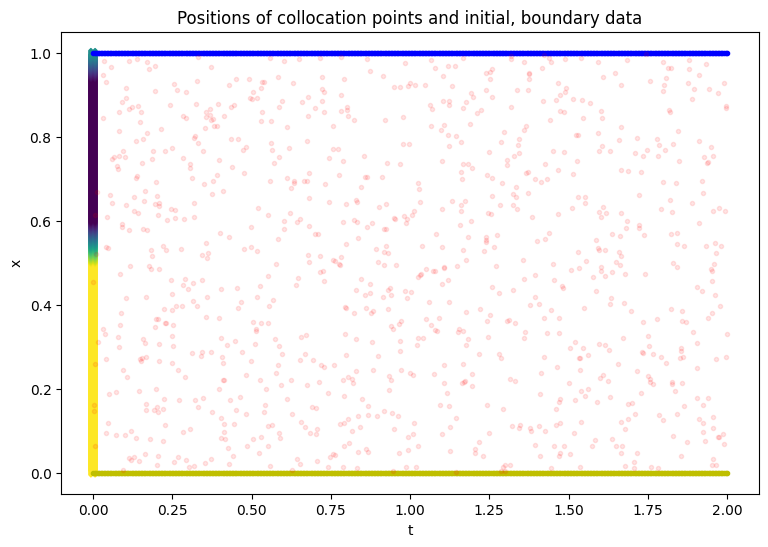

In [6]:
fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_lb, c='y', marker='.')
plt.scatter(t_b, x_ub, c='b', marker='.')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('t')
plt.ylabel('x')

plt.title('Positions of collocation points and initial, boundary data');

In [8]:
## set up neural network
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0 * (x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

In [9]:
# compute loss and gradient
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(u_t, u_xx, x)

In [11]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

In [12]:
def compute_loss(model, X_r, X_data, u_data)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [13]:
loss = compute_loss(model, X_r, X_data, u_data)

In [16]:
# get gradient with respect to trainable variables from neural network
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [17]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [18]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 5000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


It 00000: loss = 1.23248491e+01
It 00050: loss = 4.45543814e+00
It 00100: loss = 3.59614563e+00
It 00150: loss = 3.04952121e+00
It 00200: loss = 2.61871028e+00
It 00250: loss = 2.25371480e+00
It 00300: loss = 1.93189037e+00
It 00350: loss = 1.61023259e+00
It 00400: loss = 1.38634002e+00
It 00450: loss = 1.19195938e+00
It 00500: loss = 1.04573488e+00
It 00550: loss = 8.72402132e-01
It 00600: loss = 7.93473184e-01
It 00650: loss = 7.05620944e-01
It 00700: loss = 4.28478867e-01
It 00750: loss = 3.50430936e-01
It 00800: loss = 2.92429507e-01
It 00850: loss = 2.24306613e-01
It 00900: loss = 2.00899377e-01
It 00950: loss = 1.46500066e-01
It 01000: loss = 2.19953194e-01
It 01050: loss = 1.21893227e-01
It 01100: loss = 1.18335515e-01
It 01150: loss = 1.15516216e-01
It 01200: loss = 1.12801991e-01
It 01250: loss = 1.10133179e-01
It 01300: loss = 1.07485346e-01
It 01350: loss = 1.04849324e-01
It 01400: loss = 1.02219462e-01
It 01450: loss = 9.95940566e-02
It 01500: loss = 9.69756916e-02
It 01550

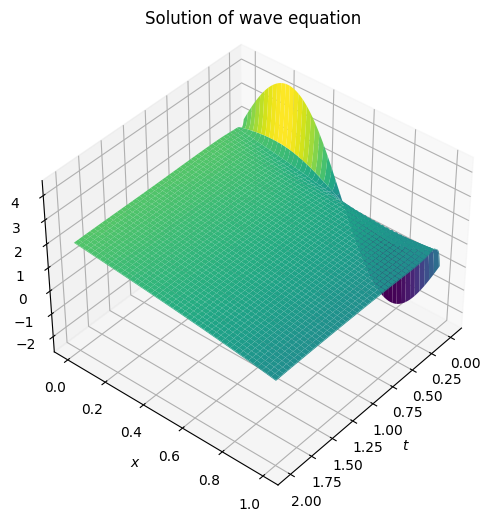

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(40,40)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_{\theta}(x,t)$')
ax.set_title('Solution of wave equation');

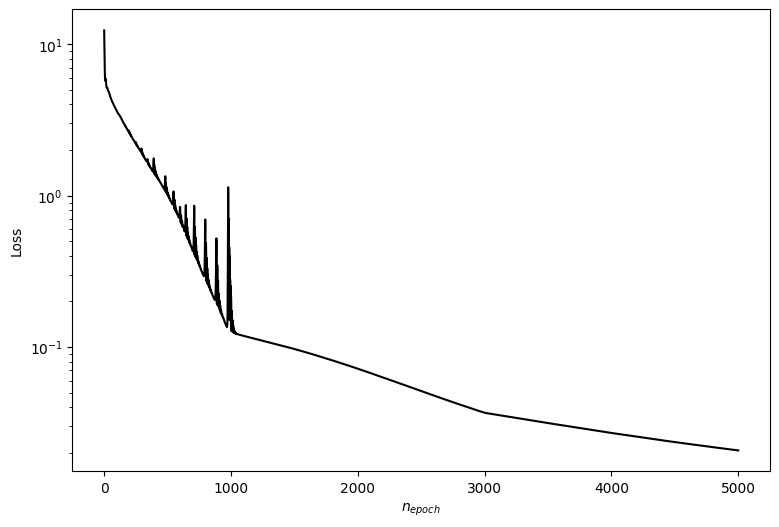

In [20]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Loss');